u
0.013952224051066662
u
0.014563562811225887
u
0.02177239980421112
u
0.007935667588378758
u
0.009294845749452144
u
0.009223689944505252
u
0.008008479897756215
u
0.00965341430946746
d
-0.008441243674699336
u
0.00829821049329996
d
-0.0105869865672773
d
-0.007511387567355467
d
-0.009658347672305839
d
-0.009658284276046562
d
-0.008012963277303376
d
-0.01523977966042353
d
-0.012019235277611133
d
-0.00744005476418324
d
-0.009086595091775729
d
-0.007441536810966272
d
-0.007655688167837895
d
-0.01016052008662359
d
-0.008800681996541725
d
-0.007513310780593219
d
-0.01101874377506031
u
0.007513374199996177
d
-0.008156860832515487
d
-0.010303921605410918
d
-0.010018589069003686
d
-0.011090800122720589
d
-0.010662224698377005
d
-0.008944943157272525
d
-0.009661110746264691
u
0.008229364217381739


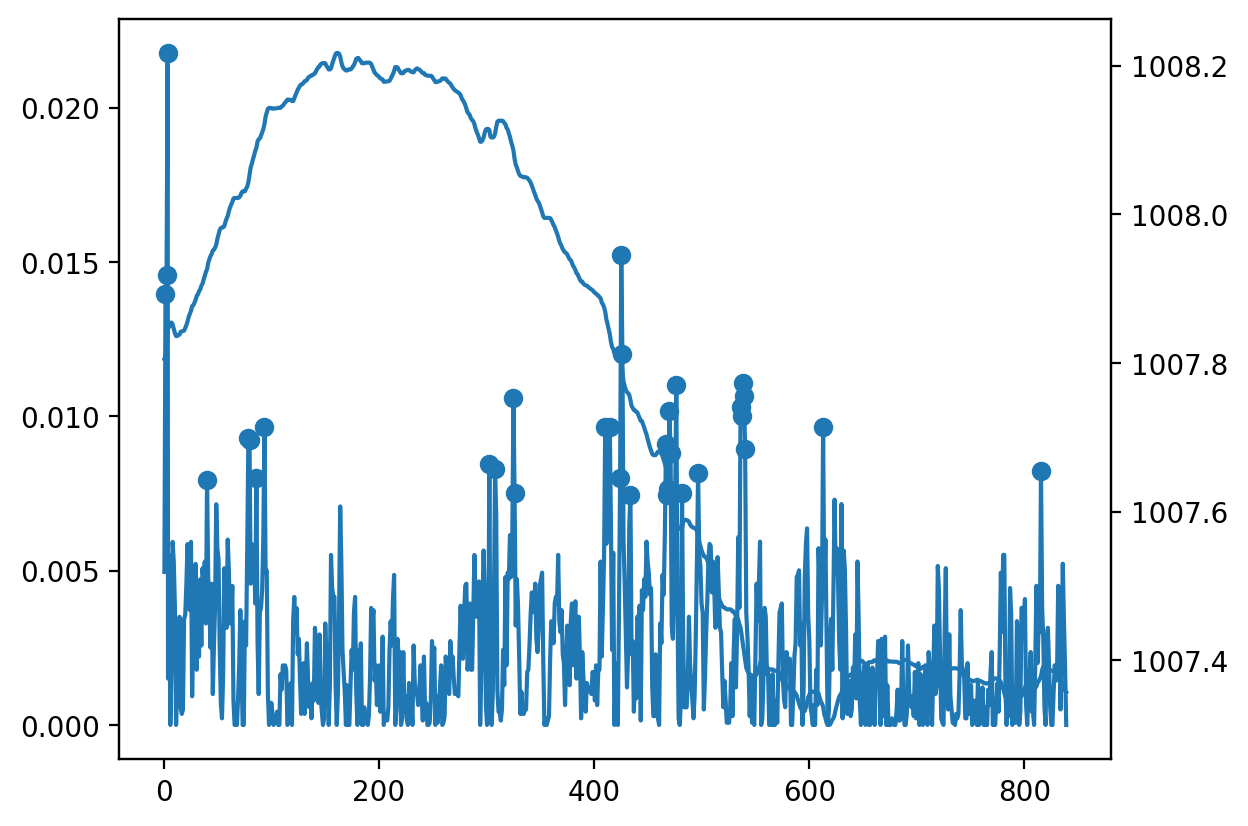

In [6]:
import pandas as pd #package for reading data
import graphlib
import statistics
import matplotlib.pyplot as plt #package for plots
import gmplot 

def der(x,y):
  """
  derivative of column y of sheet x
  """
  i = 0
  time = x['time']
  value = x[y]
  slopes = []
  aslopes = []
  times = []

  while i < len(x)-1: 
    x0, x1 = time.iat[i], time.iat[i+1]
    y0, y1 = value[i], value[i+1]
    numerator = y1-y0
    num = numerator
    if numerator < 0 :  # somehow abs() doesn't work
      numerator *= -1
    slope = numerator/(x1-x0)
    aslope = num /(x1-x0)
    slopes.append(slope)
    times.append(x0)
    aslopes.append(aslope)
    i+=1
  slopes.append(0)
  times.append(0)
  aslopes.append(0)
  return [slopes,times,aslopes]

gps_data = pd.read_csv('GPS.csv')
pressure_data = pd.read_csv('Pressure.csv')

latitude = gps_data["Latitude"]
longitude = gps_data["Longitude"]
gps_time = gps_data["time"]

bar = pressure_data["Pressure"]
bar_time = pressure_data["time"]
deri = der(pressure_data,'Pressure')
der_p = deri[0]
der_t = deri[1]
der_a = deri[2]

mean = statistics.mean(der_p)
std = statistics.stdev(der_p)
range = der_p[0] + std

range_p = []
range_p_flat = []
range_t = []
range_t_flat = []
range_a = []
range_a_flat = []
for i in der_p:
  if i >= range:
    range_p.append(i)
    range_t.append(der_t[der_p.index(i)])
    range_a.append(der_a[der_p.index(i)])
  else:
    range_p_flat.append(i)
    range_t_flat.append(der_t[der_p.index(i)])
    range_a_flat.append(der_a[der_p.index(i)])

# for n in range_a:
#   if n > 0 :
#     print("u")
#     print(n)
#   else:
#     print("d")
#     print(n)

fig, ax = plt.subplots()
fig.set_dpi(200)
# ax.plot(abs_t,abs)
ax.plot(bar_time,der_p)
ax.scatter(range_t,range_p)
ax2 = ax.twinx()
ax2.plot(bar_time,bar)
plt.show()

gps_hill_la = []
gps_hill_lo = []
i = 0
x = 0
while i < len(range_t)-1:
  for n in gps_time:
    if (range_t[i] <= n <=range_t[i+1]):
      gps_hill_la.append(latitude[x])
      gps_hill_lo.append(longitude[x])   
      x = x + 1
  i = i + 1 

lat = latitude.iat[0]
log = longitude.iat[0]

gmap = gmplot.GoogleMapPlotter(lat, log, zoom=18)
gmap.plot(latitude, longitude, '#771c2f', size = 0.5, marker = False )
gmap.scatter(gps_hill_la, gps_hill_lo, '#16EBF9', size = 0.5, marker = False  )
gmap.draw( "mapping.html" )

print(len(range_p))
print(len(bar))

